In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml
import sys

from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

In [3]:
df_inputation_schema = pd.read_csv(
    AbsolutePathBuilder.get_path(
        "00_inputation_schema",
        filepaths="../../../../config/filepaths.yaml"
    )
)
df_data_desc = pd.read_csv(
    AbsolutePathBuilder.get_path(
        "00_youtube_data_description",
        filepaths="../../../../config/filepaths.yaml"
    )
)

bins = np.linspace(0, 1, num=20)

---

### Toxicity Score Cumulative Distribution Function (CDF)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.20s/it]
/tmp/ipykernel_336437/568403044.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


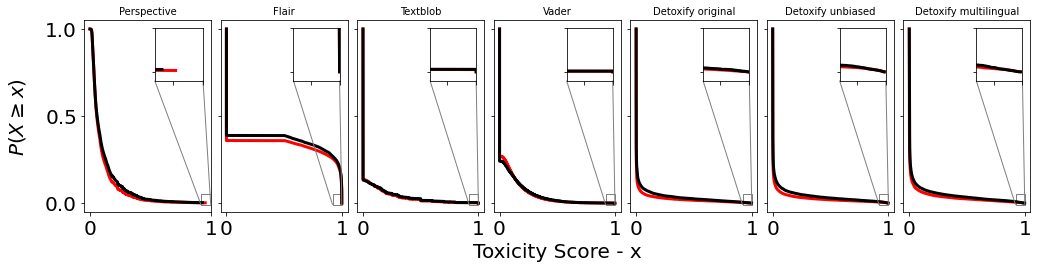

In [10]:
group_color = {
    "White": "red",
    "Black": "black",
}

fig, axs = plt.subplots(1, 7, figsize=(15, 4), sharey=True)

for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "perspective",
            "flair",
            "textblob",
            "vader",
            "detoxify_original",
            "detoxify_unbiased",
            "detoxify_multilingual"
        ]
    )
):
    axins = zoomed_inset_axes(axs[i], 5, loc=1)
        
    # Transforms the groups into White or Black
    df_data_desc["group"] = df_data_desc.group.apply(lambda s: s.split()[0])
    for group in group_color.keys():
        group_urls = df_data_desc[df_data_desc.group == group]    
        filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]

        dfs = []
        count = 0
        for filename in filenames:
            try:
                input_path = AbsolutePathBuilder.get_path(
                    "04_youtube_scored",
                    filepaths="../../../../config/filepaths.yaml"
                )
                df = pd.read_csv(os.path.join(os.path.join(input_path, filename)))
                dfs.append(df)
            except:
                count += 1

        df = pd.concat(dfs)
        del dfs

        ecdf = ECDF(df[f"{SCORE_NAME}_score"])
        axs[i].plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])

        # Add a subaxis with the same traces
        axins.plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
        
    axs[i].set_title(f"{SCORE_NAME.replace('_', ' ').capitalize()}", fontsize=10)

    # The slice of the axis that will be zoomed in
    axins.set_xlim(0.92, 1)
    axins.set_ylim(-0.01, 0.05)

    # Draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(axs[i], axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
    plt.xticks(visible=False)
    plt.yticks(visible=False)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Toxicity Score - x")
plt.ylabel(r"$P(X \geq x)$")
plt.tight_layout(pad=0)
plt.savefig(
    os.path.join(
        AbsolutePathBuilder.get_path(
            "youtube_imgs",
            filepaths="../../../../config/filepaths.yaml"
        ),
        f"youtube_icdfs.pdf"
    )
)
plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [5]:
for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "perspective",
            "flair",
            "textblob",
            "vader",
            "detoxify_original",
            "detoxify_unbiased",
            "detoxify_multilingual"
        ]
    )
):
dfs = []
for group in df_data_desc["group"].unique():
    group_urls = df_data_desc[df_data_desc.group == group]    
    filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]
    
    df_group = []
    count = 0
    for filename in filenames:
        try:
            input_path = AbsolutePathBuilder.get_path(
                "04_youtube_scored",
                filepaths="../../../../config/filepaths.yaml"
            )
            df = pd.read_csv(os.path.join(os.path.join(input_path, filename)))
            
            df_group.append(df)
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df_group = pd.concat(df_group)
    df_group["group"] = group

    dfs.append(df_group)

df = pd.concat(dfs)
del dfs, df_group

ks_all = []
groups = df.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            df[df.group == first_group][score_name],
            df[df.group == second_group][score_name]
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

IndentationError: expected an indented block (1146148982.py, line 14)

In [ ]:
pd.DataFrame(ks_all, columns=groups, index=groups)